In [2]:
import os, sys, json
from pathlib import Path, PosixPath
import imageio
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from scipy.spatial.transform import Rotation

from Nerfacito.Rendering import get_rays, initialize_rays, apply_camera_transformation, euler_to_rotation_matrix, create_homogeneous_matrix, rendering
from Nerfacito.Model import Voxels

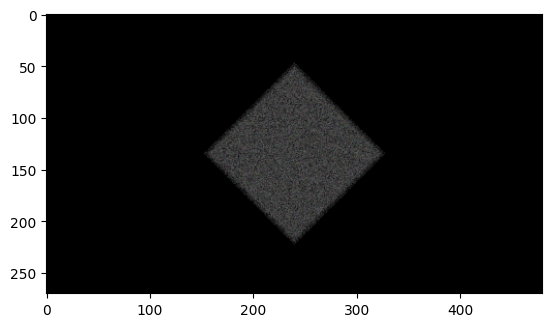

In [3]:
model = Voxels(scale=0.1)
ro,rd = initialize_rays(270,480, 1200,1200)
H = euler_to_rotation_matrix([45,0,0])
H = create_homogeneous_matrix(H)
H[2,3] = 1
ro,rd = apply_camera_transformation(ro,rd,torch.Tensor(H))
img = rendering([model],ro,rd)

plt.imshow(img.reshape(270,480,-1).detach().numpy())

In [4]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/experiment_1',flush_secs=3)

def training(model, data_loader, optim, loss_fn, scheduler, tn, tf, nb_bins, nb_epochs, N, device="cpu"):
    os.makedirs("./outputs", exist_ok=True)
    training_loss = []
    for epoch in range(nb_epochs):
        step = 0
        for batch in tqdm(data_loader):
            r_o = batch[:,:3].to(device)
            r_d = batch[:,3:6].to(device)
                        
            pred = rendering([model],r_o,r_d,tn,tf,nb_bins,device)
            gt  = batch[:,6:].to(device)
            loss = loss_fn(pred,gt)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            training_loss.append(loss.item())
            
            # Log the loss value to TensorBoard
            writer.add_scalar('Loss/train', loss.item(), step)
            step+=1
            
            if step%500==0:
                with torch.no_grad():
                    idx = random.randint(0,N-1)
                    img_pred = rendering([model],rays_o[idx],rays_d[idx],tn,tf, nb_bins,device=device).reshape(H,W,-1).detach().numpy()
                    img_gt = gts[idx].reshape(H,W,-1).detach().numpy()
                    
                    imsave = np.concatenate((img_gt,img_pred),axis=1)
                    plt.imsave(f"./outputs/save_{epoch}_{step}.png", imsave)
            
        scheduler.step()
    
    writer.close()
    return training_loss

In [5]:
import math
def minimize_difference_forsubplots(N):
    min_diff = float('inf')
    best_pair = (1, N)
    
    for i in range(1, int(math.sqrt(N)) + 1):
        if N % i == 0:
            x = i
            y = N // i
            diff = abs(x - y)
            
            if diff < min_diff:
                min_diff = diff
                best_pair = (x, y)
    
    return best_pair

In [6]:
N = 5
rays_o, rays_d, gts,infos = get_rays(PosixPath("../scooter"), max_num_images=N,random_sample=True)

batch_size = 1024
dataloader = DataLoader(
    torch.cat((rays_o.reshape(-1,3), rays_d.reshape(-1,3), gts.reshape(-1,3)), dim=-1),
    batch_size=batch_size,
    shuffle=True
)

model = Voxels(nb_voxels=300,scale=10)
tn = 0.1
tf = 20
nb_bins=200
device="cuda:0"
nb_epochs=15
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[5,10], gamma=.5)
data_loader = dataloader
loss = torch.nn.L1Loss()

ValueError: too many values to unpack (expected 2)

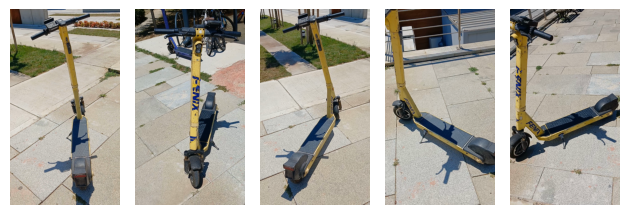

In [55]:
nrows,ncols = minimize_difference_forsubplots(N)
fig,axes = plt.subplots(nrows,ncols)
axes = axes.flatten()

# Plot each image
for i in range(N):
    axes[i].imshow(gts[i].reshape(H,W,3))
    axes[i].axis('off')  # Hide axes for a cleaner look

plt.tight_layout()
plt.show()

In [56]:
training(model, data_loader, optim, loss, scheduler, tn, tf, nb_bins, nb_epochs, N, device="cpu")

 59%|█████▉    | 1496/2532 [08:43<06:02,  2.86it/s]


KeyboardInterrupt: 

In [58]:
save_dict = {
    "model" : model,
    "tn" : 0.1,
    "tf" : 20,
    "nb_bins":200
}

In [66]:
with open("./saved_model_2024_08_16_2.pkl", "wb") as f:
    pickle.dump(save_dict, f)